# Deep learning language model

In [1]:
# importing libraries

import io
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf

from collections import Counter
from nltk.tokenize import TreebankWordTokenizer

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical

In [2]:
# variables
POST_TYPE = 'post'
MIN_TOKENS_LEN = 100
MAX_TOKENS_LEN = 200
DATA_SAMPLE_COUNT = 20000

TOKENS_MIN_COUNT = 10
SEQUENCE_WINDOW = 4
SEQUENCE_LEN = 13

### Loading the data

In [3]:
full_data = pd.read_csv('/home/adelard/ml/manning/dataset/stackexchange_full_data_tokenized.csv.gz',
                  compression='gzip').sample(frac = 1, random_state = 42).reset_index(drop = True)

### Reduce the dataset

In [4]:
data = full_data[
    (full_data.category == POST_TYPE) &
    (full_data.n_tokens > MIN_TOKENS_LEN) &
    (full_data.n_tokens < MAX_TOKENS_LEN)
].sample(DATA_SAMPLE_COUNT).reset_index(drop=True)

In [5]:
print("data.shape: ", data.shape)

data.shape:  (20000, 7)


In [6]:
print(data.text.sample(2).values)

["VEC model is a special case of VAR model. It exploits the time-series property of cointegration, i.e. that some linear combinations of unit-root time-series can be stationary. Because of this property VAR model has a special structure, which can be estimated via VECM. To apply VEC model at least two time series must be unit-root time series, because to define cointegration you need at least two unit-root time series. So the answers to your questions are No you cannot difference the non-stationary time series and then estimate VECM. Because estimating VECM on stationary time series does not make sense. Johansen's test can be applied only when all the series are non-stationary, because Johansen's test is for testing cointegration, and cointegration is defined only for unit root time series."
 "As part of my thesis, I'm proving or attempting to prove... a few asymptotic results. Because these results depend on the condition number, I'd like to have some idea about the typical sizes of a

In [7]:
# transform the tokens field from white space separated strings into list of tokens
data['tokens'] = data.tokens.apply(lambda tok: np.array(tok.split()))

In [8]:
print(data.tokens.sample().values)

[array(['the', 'r', 'package', 'igraph', 'has', 'the', 'fit', 'power',
       'law', 'function', 'which', ',', 'as', 'you', 'can', 'imagine',
       ',', 'can', 'fit', 'a', 'power-law', 'to', 'a', 'vector.', 'as',
       'you', 'can', 'see', 'in', 'the', 'reproducible', 'example',
       'below', ',', 'one', 'of', 'the', 'outputs', 'of', 'this',
       'function', 'is', 'the', 'log-likelihood', 'loglik', 'of', 'the',
       'fitted', 'parameters.', 'question', 'is', 'there', 'a',
       'rule-of-thumb', 'or', 'a', 'cut-off', 'value', 'that', 'tells',
       'when', 'the', 'loglik', 'indicates', 'a', 'good', 'bad', 'fit',
       '?', 'the', 'documentation', 'of', 'the', 'package', 'is',
       'really', 'poor', 'in', 'explaining', 'how', 'this', 'parameter',
       'should', 'be', 'considered', 'interpreted', 'reproducible',
       'example', 'library', 'igraph', 'create', 'a', 'graph', 'set.seed',
       'g', 'lt', '-', 'static.power.law.game', ',', ',', 'exponent.out',
       '.', ','

### Vocabulary

In [9]:
# generate vocabulary
# filter out words that are too scarce
import itertools
all_tokens = list(itertools.chain.from_iterable(data.tokens))

# filter out least common tokens
from collections import Counter
counter_tokens = Counter(all_tokens)


vocab_size  = len(set(all_tokens))
vocab       = list(set(all_tokens))
print("original number of tokens", len(all_tokens))
print("original vocab_size", vocab_size)


# remove all tokens that appear in less than TOKENS_MIN_COUNT times
fltrd_tokens = [ token for token in all_tokens if counter_tokens[token] > TOKENS_MIN_COUNT ]

print("nomber of tokens", len(fltrd_tokens))
print("vocab_size", len(set(fltrd_tokens)))

vocab_size  = len(set(fltrd_tokens))
vocab       = list(set(fltrd_tokens))

original number of tokens 2855851
original vocab_size 53300
nomber of tokens 2756723
vocab_size 8701


In [10]:
# filtered out tokens
filtered_out_tokens = np.unique([token for token in all_tokens if counter_tokens[token] <= TOKENS_MIN_COUNT])

In [11]:
print(filtered_out_tokens)

["'-" "'-c" "'-category" ... '𝜎' '𝜒²' '𝜔']


In [12]:
print("len(filtered_out_tokens): ", len(filtered_out_tokens))
print()
print(np.random.choice(filtered_out_tokens, 100, replace = False))

len(filtered_out_tokens):  44599

['honors' 'fitted.model' 'misinformed' 'xlm' 'philbin' 'dilip'
 'x-haloperidol' 'quadrature' 'companions' 'mascara' 'desc' 'ab-c'
 'mechanics—as' 'non-delinq' "'banana" 'y.m' 'pictured' 'administrator.'
 'wpgmc' 'capitalised' 'lts' 'fe.' 'eoi' 'extinction.' 'nice.' 'clearly.'
 "'g" 'begs' 'derivatives.' '-mass' 'user-stratified' 'repetitively'
 'sb.samp' 'sub-hourly' 'y-mx' 'roc.curve' 'tonnes' 'hyp.cov' 'tsclean'
 'modelglm' 'thoma' 'axioms.' 'polson' 'dxdy' 'fitzmaurice' 'sot'
 'concentrates' 'phyper' 'smoldyn' 'maarten' 'drifts' 'ret' 'bo'
 'bi-modal' 'co-twin' 'infection.' 'intuitiveness.' 'xvals' 'logarthim'
 'securities' 'incline' 'omiting' 'unmeaningful' 'dosages' 'neil' 'k-most'
 'springer-verlag.' 'calories' 'fakedat' 'usv' 'reconvert'
 'karhunen-loeve' 'bernd' 'gpy.models.gpregression' 'adj.mat' "l'hospital"
 'earthquakes' 'motivations' 'warp' 'xttobit' 'awkward' 'constroptim'
 'definitely.' 'photographs.' "'pond" 'sdv' 'variabels' 'anna' 'gr

### Out of Vocabulary

In [13]:
vocab.append('UNKNOWN')
vocab_size += 1

### Tokens as vocabulary indexes

In [14]:
mapping = {x: i for i, x in enumerate(vocab)}

def get_index(token):
    try:
        return mapping[token]
    except:
        return mapping['UNKNOWN']
    
data['tokens_index'] = data.tokens.apply(lambda tokens: np.array([get_index(token) for token in tokens]))

In [15]:
print(data.tokens_index.head(3).values)

[array([1131, 7836, 7013,  939, 8541, 8561, 8701,  502, 1279, 7609, 8506,
       1131, 4799, 2640, 6600, 3843, 4604, 5940, 7459, 8701, 3720, 6600,
       7609, 8541,  193,  502,  784, 1953, 3890, 3986,  502,  891, 3398,
       2912, 3767, 8541,  193,  502, 5179, 8627, 1422, 5940,  502, 8541,
       7756, 4604, 5940, 7609, 5744, 5727, 7888,  238, 8701, 6600, 3720,
       8541, 2497,  290, 7426, 8701,  502, 1279, 5387, 1953, 7679, 8075,
       6978, 7609, 3450, 5727, 1729, 7274, 3465,  223, 7609, 2912, 8541,
       1015, 4783, 5744, 6600, 3537, 5860, 1696, 3720, 6164, 8541, 3100,
       1141, 7609, 2596, 2070, 3361, 6979,   44, 7609, 2941, 4825, 4897,
       7902, 6243, 6454, 3897, 1843, 7459, 3450, 2174])
 array([4709, 7429, 6600, 3720, 2354, 4611, 4609, 2160, 7110, 5516, 2452,
       8541, 4801,  502, 8541, 3473, 2347, 5578, 7434, 3542, 1131, 5228,
       1729, 3897, 2160, 8036, 2745, 7758, 3890, 2116, 4199, 2174, 4709,
       3761, 6600, 6432, 4181, 2063,  151, 2347, 1131, 3675, 2640,

### Sequence generation

In [16]:
def sequence_generation(word):
    sequences = []
    _end = SEQUENCE_WINDOW
    while _end < len(word) + SEQUENCE_WINDOW:
        sequences.append(word[:_end])
        _end += SEQUENCE_WINDOW
        
    padded_seq = pad_sequences(sequences, maxlen=SEQUENCE_LEN, padding='pre')
    return padded_seq

In [17]:
# using the sequence generation
tokens_sequences = data.tokens_index.apply(sequence_generation)

In [18]:
from tqdm import tqdm

x = 0
for seq in tqdm(tokens_sequences.values):
    if x == 0:
        all_seq = seq
    else:
        all_seq = np.concatenate((all_seq, seq))
    x += 1
    
print("Sequences.shape: ", all_seq.shape)

100%|██████████| 20000/20000 [00:46<00:00, 431.75it/s] 

Sequences.shape:  (721510, 13)


In [26]:
# sample n% of the sequences to reduce the input dataset (optional)

if True:
    mask = np.random.choice([False, True], len(all_seq), p=[0.50, 0.50])
    sequences = all_seq[mask].copy()
else:
    sequences = all_seq.copy()

print("Sequences.shape: ", sequences.shape)

Sequences.shape:  (361110, 13)


In [27]:
# predictors and labels for the classification task

predictors = sequences[:,:-1]
label = sequences[:,-1]

print("Predictors.shape: ", predictors.shape)
print("Label.shape: ", label.shape)

# keras to_categorical function transform the vocab_size vector of labels into a one hot encoded matrix
# dimension (n, vocab_size)
label_category = to_categorical(label, num_classes=vocab_size)
print("Label_category.shape: ", label_category.shape)

Predictors.shape:  (361110, 12)
Label.shape:  (361110,)
Label_category.shape:  (361110, 8702)


### Model

In [29]:
# define model

embedding_dim = 64

dl_model = Sequential()
dl_model.add(Embedding(vocab_size, embedding_dim, input_length=SEQUENCE_LEN -1))
dl_model.add(LSTM(128, return_sequences=True))
dl_model.add(LSTM(64))
dl_model.add(Dense(vocab_size, activation='softmax'))
optimizer = RMSprop(lr=0.01)

dl_model.compile(loss='categorical_crossentropy', 
                optimizer=optimizer,
                metrics=['accuracy'])

print(dl_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 12, 64)            556928    
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 8702)              565630    
Total params: 1,270,782
Trainable params: 1,270,782
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
# model fitting

dl_model.fit(predictors, label_category, batch_size = 256, epochs=4, verbose=1)

Epoch 1/4
1411/1411 [==============================] - 117s 83ms/step - loss: 5.7974 - accuracy: 0.1200
Epoch 2/4
1411/1411 [==============================] - 116s 82ms/step - loss: 5.5762 - accuracy: 0.1644
Epoch 3/4
1411/1411 [==============================] - 116s 82ms/step - loss: 5.5196 - accuracy: 0.1786
Epoch 4/4
1411/1411 [==============================] - 117s 83ms/step - loss: 5.4760 - accuracy: 0.1848


In [31]:
# Helper function to sample an index from a probability array
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [32]:
tokenizer = TreebankWordTokenizer()

def text_generation(nmax, text, temperature):
    n = 0
    tokens = tokenizer.tokenize(text)
    
    while (len(tokens) < nmax):
        n += 1
        
        tokens_index = [vocab.index(word) if word in vocab else vocab.index('UNKNOWN') for word in tokens]
        tokens_list = pad_sequences([tokens_index], maxlen=SEQUENCE_LEN-1, padding='pre')
        probas = dl_model.predict(tokens_list, verbose=0)[0]
        
        next_word_index = sample(probas, temperature = temperature)
        next_word = vocab[next_word_index]
        
        if next_word != '?':
            print(next_word, probas[vocab.index(next_word)])
            text += ' ' + next_word
            
        tokens = tokenizer.tokenize(text)
        if n > 200:
            break
    
    return text

In [33]:
text_generation(15, 'a random variable', 4)

but 0.0014471592
choice. 1.305962e-08
tomorrow 5.7891114e-08
dbscan 1.2885278e-08
large 4.0152786e-06
reject 6.6100747e-06
diamonds 1.5589986e-09
find 7.8479105e-05
conditions 5.7608635e-05
hyper-parameters 1.5598435e-07
when 0.0050398842
fill 4.516926e-06


'a random variable but choice. tomorrow dbscan large reject diamonds find conditions hyper-parameters when fill'

### Perplexity

In [36]:
SEQUENCE_WINDOW = 1

def perplexity_sentence(sentence):
    tokens = tokenizer.tokenize(sentence.lower())
    N = len(tokens)
    
    tokens_index = [vocab.index(word) if word in vocab else vocab.index('UNKNOWN') for word in tokens]
    sequences = sequence_generation(tokens_index)
    predictors = sequences[:,:-1]
    label = sequences[:,-1]
    probas = dl_model.predict(predictors, verbose=0)
    logprob = 0
    
    for i in range(N):
        p = probas[i, label[i]]
        logprob += np.log(p)
    return np.exp(-logprob / N), logprob

In [37]:
# sentence comparison - from the corpus
sentence = "I'd be happy for any guidance. My very specific setup is as follows."
print(sentence, perplexity_sentence(sentence))

I'd be happy for any guidance. My very specific setup is as follows. (301.3829084343486, -85.62572365999222)


In [38]:
# sentence comparison - from non-corpus
sentence = "They tell me that my heart misses you."
print(sentence, perplexity_sentence(sentence))

They tell me that my heart misses you. (1314.5522166093801, -64.63126230239868)


In [39]:
# sentence comparison - from the corpus
sentence = "For the standard Generalized Least Squares GLS model is the identity matrix would be most welcome!"
print(sentence, perplexity_sentence(sentence))

For the standard Generalized Least Squares GLS model is the identity matrix would be most welcome! (701.0383460059271, -111.39356398582458)


### Perplexity on corpus

In [41]:
# perplexity on a validation set
validation_data = full_data[(full_data.category == 'title') & 
                            (full_data.n_tokens > 10)].sample(100, random_state=42).reset_index(drop=True)

In [42]:
print("validation_data", validation_data.shape)

validation_data (100, 7)


In [43]:
print("validation_data sample: ", validation_data.head(3))

validation_data sample:     post_id  parent_id  comment_id  \
0    37944        NaN         NaN   
1    93935        NaN         NaN   
2   165022        NaN         NaN   

                                                text category  \
0  What are easy to interpret, goodness of fit me...    title   
1  How to make stochastic gradient descent algori...    title   
2  Expectation of a random variable and the indic...    title   

                                              tokens  n_tokens  
0  what are easy to interpret , goodness of fit m...        16  
1  how to make stochastic gradient descent algori...        12  
2  expectation of a random variable and the indic...        11  


In [55]:
def perplexity_corpus(corpus):
    corpus_sentences = ''.join(corpus)
    corpus_tokens = tokenizer.tokenize(corpus_sentences.lower())
    N = len(corpus_tokens)
    logproba = 0
    perplex_result = []
    
    for sentence in corpus:
        perplex, logpro = perplexity_sentence(sentence)
        logproba += logpro
        perplex_result.append(perplex)
        
        print("{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{}".format(
            perplex, np.mean(perplex_result), logpro, logproba, np.exp(-logproba / (N)), sentence))
        
    return np.exp(-logproba / (N)), perplex_result

In [56]:
corpus = validation_data.tokens.values
perplexity_score, scores = perplexity_corpus(corpus)
print("Perplexity corpus: {:.2f}".format(perplexity_score))

222.97	222.97	-86.51	-86.51	1.07	what are easy to interpret , goodness of fit measures for linear mixed effects models ?
412.05	317.51	-72.25	-158.77	1.12	how to make stochastic gradient descent algorithm converge to the optimum ?
797.01	477.34	-73.49	-232.26	1.19	expectation of a random variable and the indicator random variable proof
1589.74	755.44	-95.83	-328.08	1.27	neural network gives exact same values of previous day for day ahead prediction
141.49	632.65	-64.38	-392.46	1.33	can someone explain the concept of ancillary statistics in layman 's terms ?
1283.29	741.09	-93.04	-485.51	1.43	why are n't gaussian activation functions used more often in neural networks ?
314.63	680.17	-63.27	-548.77	1.49	given a frequency distribution , calculate probability of a given b
5877.15	1329.79	-112.82	-661.60	1.62	stata demean and detrend after dickey-fuller do not reduce p-value to insignificant levels
1025.92	1296.03	-83.20	-744.80	1.73	controlling for overall economic factors and seasonality

1010.34	3099.59	-131.44	-6336.46	103.41	what is the rationale behind lars-ols hybrid , i.e. using ols estimate on the variables chosen by lars ?
2121.66	3086.72	-107.24	-6443.70	111.86	why create a generator manually for neural network when keras has built-in generators ?
703.33	3055.77	-85.23	-6528.93	119.06	dealing with hierarchical panel , multi-level data and fixed effects in lasso ?
10920.28	3156.60	-111.58	-6640.51	129.19	fitting probability distribution to failure data with discrete , right censored stress
797.43	3126.73	-80.18	-6720.68	137.00	testing large dataset for normality - how and is it reliable ?
16.96	3087.86	-36.80	-6757.49	140.74	what is the distribution of the sample variance of the skellam distribution ?
214.27	3052.38	-59.04	-6816.53	146.96	meta-analysis how to find the mean age of all studies ?
4669.35	3072.10	-109.83	-6926.36	159.26	rnorm gives me x coordinate or y coordinate of normal distribution graph ?
240.21	3037.98	-82.22	-7008.58	169.14	how to answer a cl

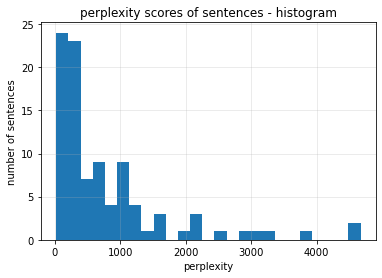

In [59]:
%matplotlib inline

plt.title("perplexity scores of sentences - histogram")
plt.hist([score for score in scores if score < 5000], bins = 25)
plt.xlabel('perplexity')
plt.ylabel('number of sentences')
plt.grid(alpha = 0.3)
plt.show()